In [1]:
!pip install transformers

     |████████████████████████████████| 778kB 2.9MB/s 
     |████████████████████████████████| 3.0MB 10.8MB/s 
     |████████████████████████████████| 1.1MB 38.1MB/s 
     |████████████████████████████████| 890kB 42.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=c53d6676cd0c5802d0581556c9f457756cf9f4ce98b15ed6ed37e088257aa836
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer
import torch
from transformers import BertForQuestionAnswering
import numpy as np
import pandas as pd
import re
import openpyxl

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:


tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')



model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')



In [4]:
# Most code in this cell taken from https://colab.research.google.com/drive/1uSlWtJdZmLrI3FCNIlUHFxwAJiSu2J0-
 
# Use plot styling from seaborn.
sns.set(style='darkgrid')
 
# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)
 
def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)
    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))
 
    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)
 
    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1
    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a
 
    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b
    
    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)
    
    # ======== Evaluate ========
    # Run our example question through the model.
    start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                    token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text
 
    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)
    
    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
 
    # Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
    s_scores = start_scores.detach().numpy().flatten()
    e_scores = end_scores.detach().numpy().flatten()
 
    # We'll use the tokens as the x-axis labels. In order to do that, they all need
    # to be unique, so we'll add the token index to the end of each one.
    token_labels = []
    for (i, token) in enumerate(tokens):
        token_labels.append('{:} - {:>2}'.format(token, i))
 
    # Create a barplot showing the start word score for all of the tokens.
    ax = sns.barplot(x=token_labels, y=s_scores, ci=None)
 
    # Turn the xlabels vertical.
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
 
    # Turn on the vertical grid to help align words to scores.
    ax.grid(True)
 
    plt.title('Start Word Scores')
 
    plt.show()
 
    # Create a barplot showing the end word score for all of the tokens.
    ax = sns.barplot(x=token_labels, y=e_scores, ci=None)
 
    # Turn the xlabels vertical.
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
 
    # Turn on the vertical grid to help align words to scores.
    ax.grid(True)
 
    plt.title('End Word Scores')
 
    plt.show()
 
    # Start with the first token.
    answer = tokens[answer_start]
    
    #Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]
    
    print('Answer: "' + answer + '"')
 
    return answer

Query has 14 tokens.



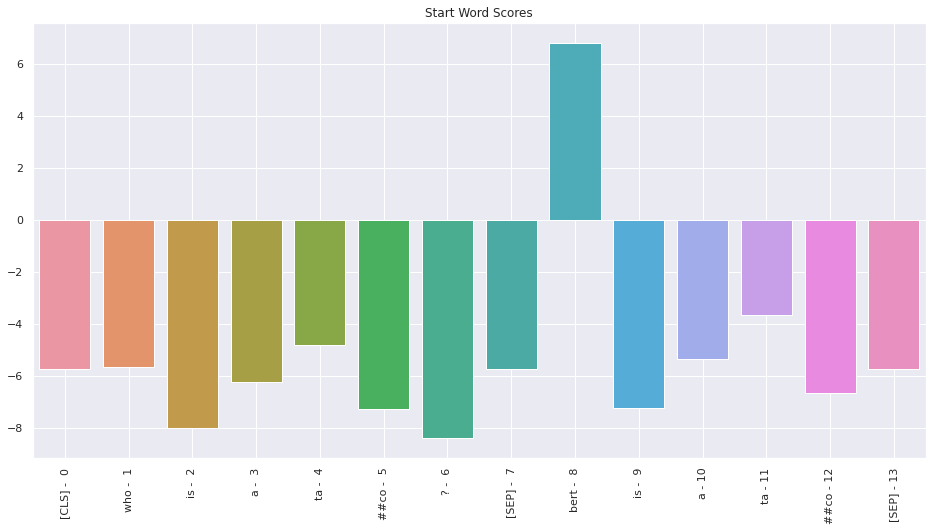

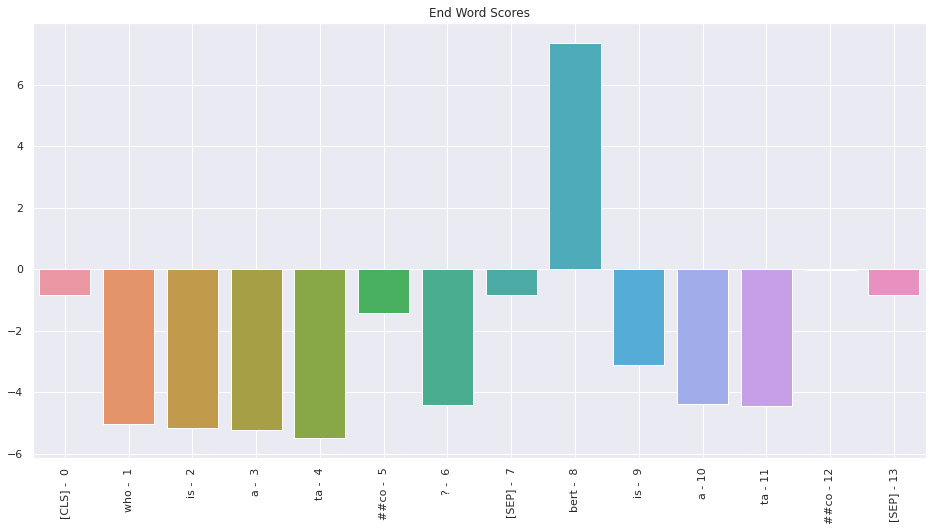

Answer: "bert"


'while True:\n    \n    qstntxt = input(\'Input refernce text (enter "q" to exit): \')\n    if qstntxt == \'q\':\n        break\n    qstn = input(\'Input question about the reference text (enter "q" to exit): \')\n    if qstn == \'q\':\n        break\n    print(\'Here is the answer to the question: \')\n    answer_question(qstn, qstntxt)'

In [5]:
#The loop can be commented in or out and texts and answers could be put here.    
answer_question('Who is a taco?', 'Bert is a taco')

'''while True:
    
    qstntxt = input('Input refernce text (enter "q" to exit): ')
    if qstntxt == 'q':
        break
    qstn = input('Input question about the reference text (enter "q" to exit): ')
    if qstn == 'q':
        break
    print('Here is the answer to the question: ')
    answer_question(qstn, qstntxt)'''

In [6]:
def answer_question_part(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Used for parts of  large text. 
    Returns the best answer and average of the max start and end scores.
    '''
      
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)
    # Report how long the input sequence is. This can be commented out if desired.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))
      
    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1
    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b
    
    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)
    
    # ======== Evaluate ========
    # Run our example question through the model.
    start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                    token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)
    
    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
    s_scores = start_scores.detach().numpy().flatten()
    e_scores = end_scores.detach().numpy().flatten()

    # We'll use the tokens as the x-axis labels. In order to do that, they all need
    # to be unique, so we'll add the token index to the end of each one.
    token_labels = []
    for (i, token) in enumerate(tokens):
        token_labels.append('{:} - {:>2}'.format(token, i))

    # Start with the first token.
    answer = tokens[answer_start]
    
    #Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]
    # Returns answer and average of max start and end scores.
    return answer,  (max(s_scores) + max(e_scores))/2


In [7]:
def longtext_answer(question, answer_text):
  '''
  To be used for longer text, using the answer_question_part function 
  (number of tokens being printed out can be removed from that if desired)
  '''
  # Average length of word, or length of slice of text, it might seem like it should be longer, but 4 give token numbers close to the max
  avg_word_len = 3
  # Max number of tokens allowed (it's always 512, for now)
  max_tokens = 512
  # Assume that the string won't have more than the average word length multiplied by the number of tokens
  increment = int(avg_word_len*max_tokens)

  # If the reference text is shorter than the increment, use the original question answer function
  if increment > int(len(answer_text)):
    return answer_question(question, answer_text)

  # List for scores for each answer for each slice of the string
  scores = []
  # List of answers for each slice of the string
  answers = []
  # Loop through the text string, in increments chosen above
  for i in range(int(len(answer_text)/increment)):
    # Checks for best answer starting from 0 in the string and appends answers and score values to lists
    ans, score = answer_question_part(question, answer_text[0+i*increment:increment+i*increment])
    answers.append(ans)
    scores.append(score)
    # Checks for best answer starting from half of the increment, in case the best answer is split between increments, and appends values
    ans, score = answer_question_part(question, answer_text[int(increment/2+i*increment):int(increment+increment/2+i*increment)])
    answers.append(ans)
    scores.append(score)
  # Gets the index for the best score  
  max_score_ind = np.array(scores).argmax()
  # Gives the answer that matches the best score index
  best_answer = answers[max_score_ind]
  # Returns the best answer
  return best_answer

In [8]:
# Text from internet, not wikipedia
test_text = '''Four distinct Yupik (or Western Eskimo) languages are spoken along the shores of the Gulf of Alaska, in southwestern Alaska, and on the easternmost tip of Siberia. The Inuit (or Eastern Eskimo) language continuum is spoken in northern Alaska, Canada, and Greenland. Another Eskimo language, the virtually extinct Sirenikski of Siberia, is usually grouped with the Yupik languages although it may actually constitute a third distinct branch.

The sound system of the Yupik branch of Eskimo differs from that of the Inuit branch perhaps principally in the following ways:

    Yupik has a fourth vowel, the shwa (like the e in the word roses), in addition to the three vowelsa, i, and u found in all Eskimo (and Aleut; Inuit as a result has two kinds of i, that from original iand that originally from the shwa),
    the Yupik languages have various forms of rhythmic alternation of stressed and unstressed syllables, while such prosodic systems are absent from Inuit,
    Yupik lacks the consonant assimilation process so common to Inuit (especially as one travels east), and
    voiceless fricatives are more prominent in Yupik than in Inuit.

As with these phonological differences, the differences in vocabulary between Inuit and any of the Yupik languages is greater than between any two Yupik languages. For example, while Inuit usesumiaq for 'boat', Yupik languages use some form of angyaq; while Yupik uses maklak for 'bearded seal', Inuit uses ugruk. Even words common to both sides will often have a distinctly Yupik version and a distinctly Inuit version. For example, the word for 'leg' is iru in all forms of Yupik and niu in Inuit, though both forms come from the same ancient Eskimo word.

Grammatical structures of Yupik and Inuit are very similar.

The four languages of the Yupik side are Alutiiq (Sugpiaq) on much of the coast of the Gulf of Alaska, Central Yup'ik of Bristol Bay and the Yukon-Kuskokwim delta, Naukanski (in 1999 still spoken by 70 people out of 400 whose ancestors spoke the language) in the East Cape area on the Chukotkan Siberian shore of Bering Strait, and Siberian Yupik on St. Lawrence Island and the facing shore of Chukotka in Siberia. Linguistically, the progression of change goes from Alutiiq to Central Yup'ik up north and over to Naukanski Yupik and then down to Siberian Yupik. Thus, these four languages form a chain via the Inuit-speaking (though formerly Yupik) Seward Peninsula. They are distinct languages with limited mutual intelligibility, and the differences between them are phonological (and morphological) as well as lexical. In addition, there is considerable dialect diversity within Alutiiq and within Central Yup'ik (though not within the other two languages). The northernmost of these languages (Siberian Yupik and Naukanski Yupik) are only slightly closer linguistically to Inuit than is the southernmost (Alutiiq).

The Inuit language is a continuum, or dialect chain, that includes Alaskan Inupiaq and stretches from Unalakleet on Norton Sound across northern Alaska and northern Canada to east Greenland. The change from west to east is marked by the dropping of vestigial Yupik-like features and increasing consonant assimilation (the word for 'thumb' goes from kumlu to kuvlu to kullu) adding to the significant gemination (consonant lengthening) already in Inuit. Lexical change is also encountered and consequently, while two adjacent dialects of Inuit are usually mutually intelligible, speakers from very distant dialects would not easily understand one another. '''

In [9]:
longtext_answer('how many yupik languages are spoken', test_text)

Query has 360 tokens.

Query has 381 tokens.

Query has 373 tokens.

Query has 273 tokens.



'four'

In [10]:
# This can work for translations
#!pip install googletrans
#from googletrans import Translator
#translator = Translator()
#print(translator.translate('hola, que tal'))
#print(translator.translate('oui, ca marche bien'))

In [11]:
# This can work to extract audio from a video file
#!pip install moviepy
#from moviepy.editor import *
#audioclip = AudioFileClip('/content/GMT20200608-182134_Facebook-L_640x360.mp4') #colab doesn't save files so this would have to be downloaded and uploaded from slack (or linked to if permissions work)
#audioclip.write_audiofile("/content/jandoc.wav")

In [12]:
# This can be used for speech recognition, 7 API's can be used, but they need keys (the default google one was meant to work but needed a key when I tried also)
#!pip install SpeechRecognition
#import speech_recognition as sr
#r = sr.Recognizer()
#docconvo = sr.AudioFile('jandoc.wav')
#with docconvo as source:
#  audioconvo = r.record(source)
#r.recognize_google(audioconvo) #need api key here

In [34]:
# Text from conversation on Slack
emtext = str("""
00:00:06
Speaker 1: Hi, Amy. How are you doing today?

00:00:11
Speaker 2: Oh, I mean. Okay, all things considering, but, you know, not so perfect as I would like.

00:00:19
Speaker 1: Okay, perfect. So I am that John. I am happy to meet you. So you have been referred to me by the Zord.

00:00:30
Speaker 1: And can you tell me a little bit of your story?

00:00:35
Speaker 2: Yeah, sure. So basically, I started to develop a loose stomach diarrhea and I noticed that the diarrhea after several days was like. Didn't seem to be clearing up. You know, on one hand, I thought it was getting better. But a week later, a week into it, a week and a half into it, I started to notice that this thing was just getting worse. And I started to get chills and I started to have fever.

00:01:13
Speaker 1: OK. So all these things have been a few years ago. Did the doctor give some name about that disease?

00:01:24
Speaker 2: No, they didn't really label it the first time this happened. They gave me antibiotics to forget what it was called was an anaerobic antibiotic, because a lot of it is.

00:01:43
Speaker 1: It flies. It was flat.

00:01:45
Speaker 2: Yes. They thought maybe it was diverticulitis, diverticulitis, whatever it's called, something like that. And I had a call endoscopy to show some inflammation. But that's about it. Like, you know, I don't know anything.

00:02:05
Speaker 1: Yeah.

00:02:06
Speaker 1: So coming back to your background, you have brought broader. She stares. Are you alone in the family?

00:02:14
Speaker 2: No, I have actually a brother, two brothers and a sister.

00:02:20
Speaker 1: OK. Do any of them have intestinal disease? Oh, yeah. Oh, well, disease.

00:02:26
Speaker 2: Yeah. My mother has Crohn's and my nephew has ulcerative colitis.

00:02:36
Speaker 1: OK. And you personally, have you already been admitted to hospital? Apart from the one time for the most could be. Have you been hospitalized? No. Never been. So journey. No surgery in the past? No. And not related to that. But effectively. And do you have any allergy medication or allergy to foods?

00:03:06
Speaker 2: Not that I know of. I maybe I'm a bit gluten intolerant, maybe from bloating afterwords, but not necessarily diagnosed. No, think diagnose because they did that. The test is a special test where they snip the check for what's called again to check if your terminal should be on t trunk's between us. Yeah. To see if you have that, that, that disease where you can sit still.

00:03:39
Speaker 1: That's right. Yes. It came back negative.

00:03:42
Speaker 1: So. So you never had the upper through intestinal and this could be. Never did that.

00:03:49
Speaker 1: I actually did have that, so and it was also no money. Yeah, I was sort of sort of no in-between.

00:03:59
Speaker 1: So I've never had any chronic disease like heart, high blood pressure, diabetes, nothing about Aldo's disease. Do you really glum?

00:04:15
Speaker 1: No meeting, no thyroid gland. OK. OK. Pressure, blood pressure.

00:04:23
Speaker 2: OK.

00:04:26
Speaker 1: And and all about heart disease or cardiac disease or lung disease. Nothing like that.

00:04:37
Speaker 2: No. I myself have never been diagnosed with it.

00:04:42
Speaker 1: Currently, do you take any medication?

00:04:49
Speaker 2: Right at the moment, they don't take don't take anything. Nothing.

00:04:54
Speaker 1: Perfect. So we are going to speak about the NTSC now. Are we about the intestinal hoax? Let's see. I'm going to ask you some question about your Bowell beats. And you tried to give the unsearched related to the past seven days. You agreed with that. Perfect for to begin with. Do you have abdominal pain in the past seven days?

00:05:22
Speaker 1: I get some cramping.

00:05:25
Speaker 1: Some cramping. Can you tell me if it is like from zero to 10?

00:05:30
Speaker 1: Oh, much pain. Do you feel for the pain for a moment.

00:05:39
Speaker 1: Couldn't be anywhere between seven and eight. AC. And does it last very long? I'll show time. It's intermittent. Okay, perfect, Despain.

00:05:56
Speaker 1: Can you look at it is the upper part of the abdomen or lower part? All right. In the middle.

00:06:06
Speaker 1: Good question. You have never focus on that. No, I haven't focused actually on which part is a good question, though. I think I can pay attention more. Exactly. Have it.

00:06:20
Speaker 1: Absolutely. So speaking about pain. Is it like only on the front of the abdomen or sometimes it can go through the abdomen and go back like pushing your back? Oh, you know what I mean. OK. Besides that pain. Do you have any other thing like vomiting or nausea?

00:06:43
Speaker 1: No vomiting and nausea, a touch of nausea now and then after a week, but not predominant.

00:06:51
Speaker 1: Exactly about this to leave any loose stool. Oh, I like us. And the more frequent during it, they can reach out much. And you see, like, three, four, five.

00:07:05
Speaker 1: Yeah. Yeah. No, it's. It's nine.

00:07:11
Speaker 2: Yeah. Could be like, you know, it fits very loose and not, you know, retaining any form. It could be like 10 times up to 10 times.

00:07:20
Speaker 1: And do you wake up the night to go to Struhl.

00:07:24
Speaker 2: Oh, it's only during the day occasionally because I have to go to the washroom to to urinate or whatever.

00:07:34
Speaker 1: Then, you know, you do a stool also. Yeah. I never had blood during those supplies. So then there is no blood in this tube.

00:07:44
Speaker 2: Not that I could see. Not visibly.

00:07:48
Speaker 1: OK, perfect. So do you have any other things for the abdulle.

00:07:52
Speaker 1: Not to mention things I have not maybe X. About your abdominal hair. Tennis.

00:08:03
Speaker 2: No, just it's, you know, abnormal weather then than, you know, I don't like the fact that I'm running fever now.

00:08:11
Speaker 1: So you're speaking about that. You have fever. A few days. Oh, it's something very few days. Few days. Can you tell me if it is. Thirty five to thirty seven to eight to nine and go up to.

00:08:27
Speaker 1: Well, like in Fahrenheit, I switched to Fahrenheit so it could go up to 100. A little over one hundred and one. So under some one Fahrenheit. Okay. Do you have a joint pain?

00:08:44
Speaker 1: Beside. No. No. And do you ever been in that place like hurt? Headache? No. No.

00:08:53
Speaker 1: And you have noticed something on your skin. New discoloration. Something that's. That was not there. Treat in the past? No. I like the new scars which indicate that. This fever. It's very responsive to treatment. You take something for that. Like Tylenol. Yes. And it is responsive to take.

00:09:18
Speaker 2: It is responsive. But the fever comes right.

00:09:20
Speaker 1: Comes in. So what about your general well-being? Are you still be able to do your general activity? Like going to work, like doing some sport outdoors? Your state is affected by what you are said.

00:09:39
Speaker 2: Well, it's very inconvenient to be having to go to the bathroom and the papers concerning for me. So the fever also makes me tired. So I'm not myself.

00:09:53
Speaker 1: Okay, I understand. So what is the one thing you want to change?

00:10:00
Speaker 1: Which is the one thing you want. We as physician to change in your symptoms. The most important.

00:10:10
Speaker 2: Find out what's causing the fever, if it's an infection or is it inflammation is an infection. Get rid of the fever. I don't know what the protocol is.

00:10:25
Speaker 1: Finding a diagnosis and finding something. Exactly. Yeah. Good question. So have you done some self medication in those past days, taking some plants and natural products? No, nothing. And did you saw any of that third before me?

00:10:46
Speaker 2: No. Other than consulting with my GP.

00:10:49
Speaker 1: Okay, perfect. So I'm going to examine you to see how you are doing. So now you can lie on the table. I just relax. I'm doing the examination. So here is your belly. I just see my teeth hard. Okay, perfect. Deliveries will form. The spleen is no ma. And now you can you breathe deeply. Okay, then you okay, perfect. So I'm going to listen DeLong's again. The memory is clearer. The Hertz rhythm is regular. Okay, perfect. I have noticed something in the mouse and you open. Okay, perfect. I see the mouse you deliver, say, in the mouse. Do you have this often this kind of service in the mouse.

00:11:45
Speaker 1: No, not not often, not often. OK. Is it painful or not painful? Not that painful. I didn't notice it.

00:11:55
Speaker 1: Perfect. Now let me check the ice. OK. No red mass. Okay. Do you snore? Sometimes.

00:12:04
Speaker 2: I don't know, because they did so I thought occasionally I do. But I hope not too loud. Perfect.

00:12:15
Speaker 1: No, let me look behind you. Years. Okay.

00:12:18
Speaker 1: Nothing like your skin disorders in the family. You don't ask people to. Sorry, Aziz. Oh, Exuma family.

00:12:28
Speaker 1: No.

00:12:29
Speaker 1: No. And no one in the family has what we call vitiligo, which kind of discoloration of skin in the in the family? Not that I know of. No, Patrick. So I think for the physical examination, everything is OK. Oh, I forget to see the joints. Let me look. The journals, the arms, the knees and the shoulders. Everything look fine. Okay, perfect. So you can go back. Sit down. Thank you. Let me wash my hands. Shake. So what I have seen by is speaking to you and trying to see on your examination. It may be that you are Kolon is fragile. I think the first thing that I care because you are well looking. You are you appear healthy. It's might me to what you call IBS Bone Syndrome. But I need to do some procedure just to confirm that. Are you aware of what we call Colonus Cookie? Sure. OK. So I know that it's not something very happy to do, but I think it would be important to do that procedure. What do you think about that?

00:13:49
Speaker 2: I think it's great. So you want to order colonoscopy?

00:13:52
Speaker 1: Yeah. I think a colonoscopy will be helpful to understand what is going on, even though you have told me you have had one in the past. Right. Exactly. So I think we'll will be doing that because these things might change between to protect you and write something that will help us to see the mucosa of the Koran. And so for this akonting. Do you have any question about the colonoscopy? By the way?

00:14:21
Speaker 2: You know, since I have one before, I know what to expect.

00:14:25
Speaker 1: You have been explained the risk of the procedure. You know, sometimes we can have fair operations. You can have BD is very rare. But we have the right to expend deficient that it make or cure. You also know that the day before you have to drink a lot of water with clean products to in the moment. So not some day, not much time to work that day. It's really not important. The more the colonies clean, the more it will be easy to have something visible for us as physicians. So I was going to order this procedure. So the cleanest goopy form will be filled with all your information. And the appointment will be sent to you by hour. And this could be nurse. So she will call you on your cell phone because it's the one we are on FALDER. Is it OK for you to be call or text it?

00:15:29
Speaker 2: What do you prefer text to either or. It's fine. It's perfect.

00:15:34
Speaker 1: OK, whatever, Lola. I will tell the nurse to take you for this birth. The second day before the opening, this could be one of the thing I went to look, it's to try to see if there's any form of information we offer that new tests are very like acknowledge tells the contradicting fickle culture. It's very smart this you can even do it with your cell phone at home. And it's very easy to do. The name is Fake Alchol Predicting, and you can do that at home. The app is available to download and we have it each that will be used to make the. This tool analyzes. And you just take a picture with your cell phone and it gives the results. Usually that tells desk. This is very easy. I've heard of it in the past.

00:16:32
Speaker 2: Sorry. How do you spell that? It's called free.

00:16:35
Speaker 1: Is it. If he called call protecting tile c l p r o t e c c I am contradicting. OK, Chicos. So it's something that it's very easy to bear from. And usually the normal level is less than one. On Redan she's t. When you have people with more than three on. We call it the information because the information in this tool is associated with inflammation in the colon. OK. And that information might be a bacteria that have fever on all those things, are not it? It may also be like inflammation for IBD, like Quran's, such a great use. So to exclude the one or the other. It's important to do also a stool culture. So the test will be done. You can use the same stool to do both the stool culture and the physical can protect him. And in particular, when you do the stool culture, you really try to also analyze what you call C. diff. It's Clostridium difficile. So something it will be put on the order sheet. So the order sheet will include first, the Caracal put it in. And second, that the. Do you have any question about those procedures?

00:18:09
Speaker 2: Yes, sorry, the second one. What the. It's not C. difficile, it's called.

00:18:13
Speaker 1: Yeah. It's the same sear is the presidium. It's the abbreviation C. diff is Clostridium difficile. OK. It's just that every ideation is. Yeah.

00:18:26
Speaker 1: This is the Shults form for Clostridium. It's kind of like bacteria that happens to colonize the colon. So this this is one of the aspect of trying to rule out infection. And if those things are well out of the colon, those could be we've gone through EDAR. So the level of inflammation either root out Crohn's or colitis. And finally, we can conclude of IBS that do something without inflammation. And we think about what those causes and the treatment afterwards. And the last thing is the blood test. So I order also. But this week I'll be mean and we'll grubin see upby sedimentation rate, liver, enzyme. I'll t get my duty. And I hope that the computer would write it on the blood test.

00:19:35
Speaker 1: Do you know. Yeah, they know where we are.

00:19:38
Speaker 1: You will be doing those tests in which hospital you have already most people close to your home.

00:19:45
Speaker 2: Yes, I know. Well, I, I would probably go and stick with the hospital that you you're at to make it easier for you. So you have the format of the tests in the way that you're used to.

00:20:02
Speaker 1: Exactly. So as soon as we have the results of those tests, I will send you an email just to keep you informed of the rhythm. So I o organized.

00:20:13
Speaker 2: Doctor, can we organize even once you have the results. Another like a conference call or whatever.

00:20:20
Speaker 1: Absolutely. Usually I think you might have the results before the call and this could be. So maybe I'll give you the results by email. And then when I have the results of the call in this copy, I will call you to give you all the details. And more importantly, the treatment plan. Absolutely.

00:20:41
Speaker 2: That's perfect. So we can actually from here even possibly book, you know, like the next telemedicine call her.

00:20:51
Speaker 1: Absolutely. So in summary, just to summarize, because I usually finish the the appointment with so many in Somalia. So you have actually 20 years you have been since a lot of year with blood. We share a lot of to lose. And nail in. And you have had in the past, you know, my nose could be in a story. You have a broader front unassertive colitis and you are currently taking no medication. And we are planning to do two things, two things, in fact. The first thing is a blood test. The second thing, stool test. We shuttle crew and c.D. And the last thing is the colon. This could be. Is it okay? All those surmounted? Do you have anything you want to add before concluding?

00:21:50
Speaker 2: No. Excellent. Thank you so much. Greatly appreciate it.
e
00:21:54
Speaker 1: Thank you. And I hope you will have a nice day. And happy to see you next time.

00:22:01
Speaker 1: Thank you. Thank you. Thank you so much for the recording.
""")

In [35]:
# Taking out numbers, speaker references and colons from emtext, text cleaning may not be needed though
emtext_1 = emtext.replace('Speaker', '')
emtext_2 = re.sub('\d','',emtext_1)
emtext_3 = emtext_2.replace(':','')
#emtext_3

<input>:3: DeprecationWarning: invalid escape sequence \d
<input>:3: DeprecationWarning: invalid escape sequence \d
<input>:3: DeprecationWarning: invalid escape sequence \d
<input>:3: DeprecationWarning: invalid escape sequence \d
<input>:3: DeprecationWarning: invalid escape sequence \d
<input>:3: DeprecationWarning: invalid escape sequence \d
<input>:3: DeprecationWarning: invalid escape sequence \d
<input>:3: DeprecationWarning: invalid escape sequence \d
<input>:3: DeprecationWarning: invalid escape sequence \d
<ipython-input-35-2869b634b574>:3: DeprecationWarning: invalid escape sequence \d
  emtext_2 = re.sub('\d','',emtext_1)


In [36]:
longtext_answer('what symptoms does the patient have?', emtext_3)

Query has 389 tokens.

Query has 388 tokens.

Query has 377 tokens.

Query has 376 tokens.

Query has 385 tokens.

Query has 395 tokens.

Query has 394 tokens.

Query has 370 tokens.

Query has 386 tokens.

Query has 404 tokens.

Query has 388 tokens.

Query has 374 tokens.

Query has 383 tokens.

Query has 396 tokens.

Query has 409 tokens.

Query has 402 tokens.

Query has 371 tokens.

Query has 368 tokens.



'broader front unassertive colitis'

In [38]:
longtext_answer('what medication is the patient taking?', emtext_3)

Query has 389 tokens.

Query has 388 tokens.

Query has 377 tokens.

Query has 376 tokens.

Query has 385 tokens.

Query has 395 tokens.

Query has 394 tokens.

Query has 370 tokens.

Query has 386 tokens.

Query has 404 tokens.

Query has 388 tokens.

Query has 374 tokens.

Query has 383 tokens.

Query has 396 tokens.

Query has 409 tokens.

Query has 402 tokens.

Query has 371 tokens.

Query has 368 tokens.



'tylenol'

In [40]:
longtext_answer('what is the result of the patient physical exam?', emtext_3)

Query has 392 tokens.

Query has 391 tokens.

Query has 380 tokens.

Query has 379 tokens.

Query has 388 tokens.

Query has 398 tokens.

Query has 397 tokens.

Query has 373 tokens.

Query has 389 tokens.

Query has 407 tokens.

Query has 391 tokens.

Query has 377 tokens.

Query has 386 tokens.

Query has 399 tokens.

Query has 412 tokens.

Query has 405 tokens.

Query has 374 tokens.

Query has 371 tokens.



'negative'

In [41]:
longtext_answer('what is the patient main complaint?', emtext_3)

Query has 389 tokens.

Query has 388 tokens.

Query has 377 tokens.

Query has 376 tokens.

Query has 385 tokens.

Query has 395 tokens.

Query has 394 tokens.

Query has 370 tokens.

Query has 386 tokens.

Query has 404 tokens.

Query has 388 tokens.

Query has 374 tokens.

Query has 383 tokens.

Query has 396 tokens.

Query has 409 tokens.

Query has 402 tokens.

Query has 371 tokens.

Query has 368 tokens.



'colitis'

In [42]:
longtext_answer('what is the patient allergy?', emtext_3)

Query has 389 tokens.

Query has 388 tokens.

Query has 377 tokens.

Query has 376 tokens.

Query has 385 tokens.

Query has 395 tokens.

Query has 394 tokens.

Query has 370 tokens.

Query has 386 tokens.

Query has 404 tokens.

Query has 388 tokens.

Query has 374 tokens.

Query has 383 tokens.

Query has 396 tokens.

Query has 409 tokens.

Query has 402 tokens.

Query has 371 tokens.

Query has 368 tokens.



'gluten intolerant'

In [43]:
longtext_answer('what is the patient medical history?', emtext_3)

Query has 389 tokens.

Query has 388 tokens.

Query has 377 tokens.

Query has 376 tokens.

Query has 385 tokens.

Query has 395 tokens.

Query has 394 tokens.

Query has 370 tokens.

Query has 386 tokens.

Query has 404 tokens.

Query has 388 tokens.

Query has 374 tokens.

Query has 383 tokens.

Query has 396 tokens.

Query has 409 tokens.

Query has 402 tokens.

Query has 371 tokens.

Query has 368 tokens.



'[CLS]'

In [44]:
longtext_answer('what is the patient illness?', emtext_3)

Query has 388 tokens.

Query has 387 tokens.

Query has 376 tokens.

Query has 375 tokens.

Query has 384 tokens.

Query has 394 tokens.

Query has 393 tokens.

Query has 369 tokens.

Query has 385 tokens.

Query has 403 tokens.

Query has 387 tokens.

Query has 373 tokens.

Query has 382 tokens.

Query has 395 tokens.

Query has 408 tokens.

Query has 401 tokens.

Query has 370 tokens.

Query has 367 tokens.



'unassertive colitis'

In [45]:
longtext_answer("what is the patient's family medical history?", emtext_3)

Query has 392 tokens.

Query has 391 tokens.

Query has 380 tokens.

Query has 379 tokens.

Query has 388 tokens.

Query has 398 tokens.

Query has 397 tokens.

Query has 373 tokens.

Query has 389 tokens.

Query has 407 tokens.

Query has 391 tokens.

Query has 377 tokens.

Query has 386 tokens.

Query has 399 tokens.

Query has 412 tokens.

Query has 405 tokens.

Query has 374 tokens.

Query has 371 tokens.



"crohn ' s"

In [16]:
# Shorter text from Slack
test_textdoc = str("""Jeremie and Doctor
doctor:
[00:00:01]
Hello Jérémie! How is he?
[00:00:06]
It's going well, thank you, it's going very well. So today we are making a visit
for monitoring ulcerative colitis.
doctor:
[00:00:16]
How are you already feeling in general? How to know these days
in terms of illness?
Jeremie:
[00:00:23]
Well good enough, it's been long enough that I haven't had any
upset stomach or big stomach problems. Dimensions, things are going pretty well.
doctor:
[00:00:38]
So we're going to go back a little bit on your story. So you
corrects me if I'm wrong. So, you were diagnosed 5 years ago. You had blood
in the stool and we had a colonoscopy at that time.
doctor:
[00:00:52]
And then I prescribed a medicine called Ben
Basat that you started. And then, during the last visit, 6 months ago, you told me
said I take it from time to time and. After all that, we had done tests
blood and stool. Three months ago. Is this right?
Jeremie:
[00:01:14]
Yeah, yeah, that's fine.
doctor:
[00:01:18]
Since the last visit, six months ago, has there been any
new health problems other than this digestive problem?
Jeremie:
[00:01:27]
I and I have a bit of recurrent constipation, but who happens, who
happens periodically, but otherwise, other than that, it's pretty good.
[00:01:49]
Stomach odor or going to a hospital didn't have surgery.
[00:01:56]
No, no, no, no, it's just uncomfortable. This pendulum says it's not
something that me. It is painful, but each time it is uncomfortable.
[00:02:14]
It doesn't stop activities.
[00:02:18]
No, no is not a problem, but it is fair. Something I noticed.
Okay.
[00:02:29]
Do you have allergies? Energetically speaking of the treatment, the
medicine you call penta. Do you take it regularly?
[00:02:44]
I know, I try and manage most of the time, I manage to take it at the right
moment.
[00:02:54]
Sometimes I have major oversights. The vast majority of the time, I take it
as prescribed.
[00:03:02]
But have you noticed the side effects of things? You
take the medication for discomfort. You have.
[00:03:12]
No, no, really, the nail problem, no. One in the mouth.
[00:03:21]
No, no, I don't want to see anything. They didn't notice anything either in terms of
my digestive system also makes a lot of effort to change my diet. Try the
make it a little healthier. I don't know if it does, but during this time, you
eat less gum food or more vegetables, more fruit. It seems more to me
balanced. Less fat, less research, okay.
[00:04:01]
Speaking of food, is there anything you have
noticed when you eat more than it gives you bowel trouble? Some
food?
[00:04:17]
I like to eat spicy a lot. Sometimes I noticed. Let's say i have some
problems, I eat too often over a period of time. If I have several meals
close together, it is without cause certain problems. Know, it's something I have
also written anyway. No, no, that's not right.
[00:04:56]
No one has bowel problems or illnesses.
[00:05:03]
There, I have a grandfather who has constipation. It's like that,
fairly recurring, which has had that for a very, very long time. The child who is now
Having to take extra fiber is like a routine for taking this.
[00:05:28]
But we haven't had a case of Crohn's disease or politics.
[00:05:35]
No no.
[00:05:39]
Now let's talk about these current disorders in the intestine.
When it hurts, it's more before or after meals.
[00:05:50]
No, it is rather after almost three hours after that. In the near future,
but there it takes a little time.
[00:06:04]
Is there water like blood in the stool or loose stool?
[00:06:13]
Stan no, not until it happens with the maximum.
[00:06:24]
The maximum in a day is the maximum of times I do
dirty.
[00:06:36]
It can go three times, but in general, it's more like two to happen
regularly on their entry into the details, the consistency of the stool is not
always the same. Former candidates, I imagine. It's a bit normal too.
[00:07:00]
And then at night wake him up to go and do the dishes.
[00:07:04]
Or else I sleep all night.
[00:07:15]
But now, lifestyle habits that you take, alcohol, wood,
the alcohol.
[00:07:22]
Yeah, yeah, I think I still cut down on alcohol,
but I always drink, I managed easily.
[00:07:36]
Easily three times a month, the equivalent of a glass of beer or a glass of
whiskey.
[00:07:45]
Maybe two glasses of beer three times a week like that.
[00:
Send feedback
History
Saved
Community""")

In [17]:
# Cleaning test_text 
test_text_1 = test_textdoc.replace('Jeremie', '')
test_text_2 = test_text_1.replace('doctor', '')
test_text_3 = test_text_2.replace('[', '')
test_text_4 = test_text_3.replace(']', '')
test_text_5 = test_text_4.replace(':', '')
test_text_6 = re.sub('\d','',test_text_5)
#test_text_6

In [18]:
longtext_answer('what is the checkup visit for?', test_text_6)

Query has 386 tokens.

Query has 381 tokens.

Query has 386 tokens.

Query has 383 tokens.



'monitoring ulcerative colitis'

In [48]:
longtext_answer('what are the patient symptoms?', test_text_6)

Query has 384 tokens.

Query has 379 tokens.

Query has 384 tokens.

Query has 381 tokens.



'[CLS]'

In [54]:
# How to write to an excel file and save a copy with python, file needs to be uploaded each time on google colab
#myworkbook = openpyxl.load_workbook(r'/content/IC-Medical-Chart-Template-10541.xlsx')
#myworkbook.get_sheet_names()

In [55]:
# May need to click on folder to see the file after saving
#worksheet= myworkbook.get_sheet_by_name('Medical Chart Template') 
#print(worksheet['B10'].value)
#print(worksheet.cell(row = 5, column = 2).value)
#worksheet['C10']='We are writing to C10'
#myworkbook.save('IC-Medical-Chart-Template-10541_filled.xlsx')

In [49]:
# Added "Patient complaint is headache."
headache_conv = str("""
Conversation about headache

Patient: Doctor, I’ve headache since yesterday evening.

Doctor: Have you taken any medicine so far? Patient complaint is headache.

Patient: Saridon, but the headache hasn’t disappeared.

Doctor: You’ve a running nose. Looks like your headache is a result of sinus infection, and not the regular one that results from anxiety and fatigue. Lemme check.

(The doctor checks the patient thoroughly.)

Doctor: It’s quite clear that the infection in your sinus is the reason for your headache. I’ll prescribe an antibiotic to clear the infection and a pain reliever to relieve the pain.

Patient: Thank you, doctor.

""")

Query has 149 tokens.



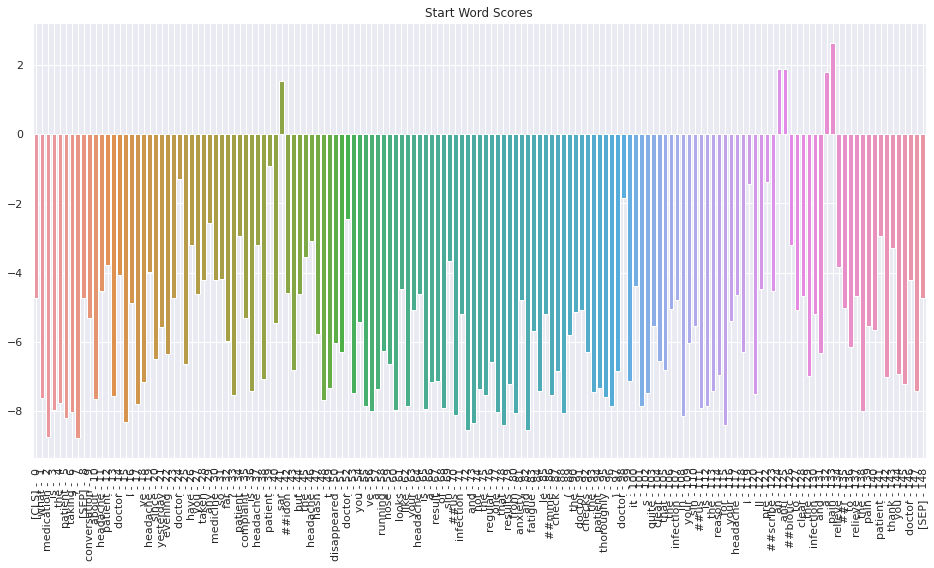

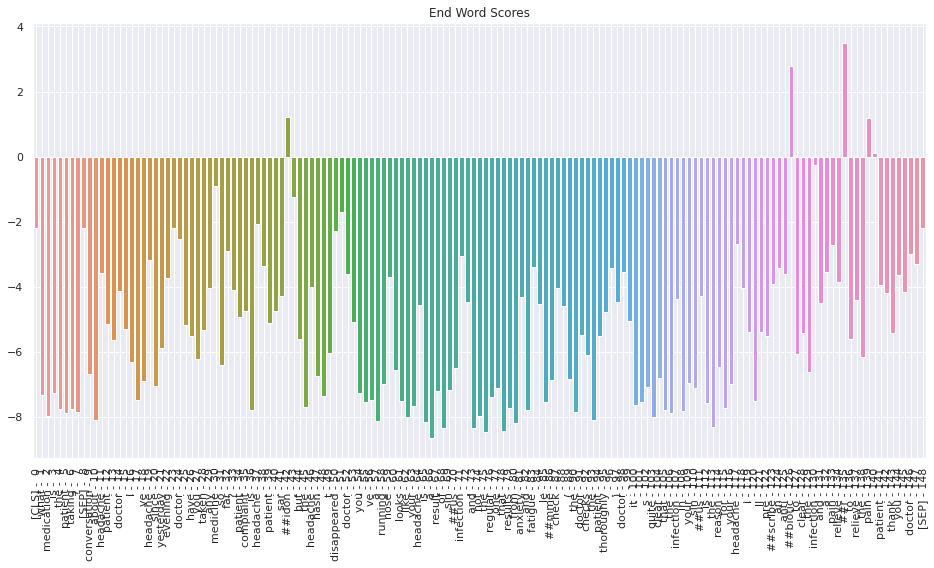

Answer: "pain reliever"


'pain reliever'

In [50]:
longtext_answer('what medication is the patient taking?', headache_conv)

Query has 149 tokens.



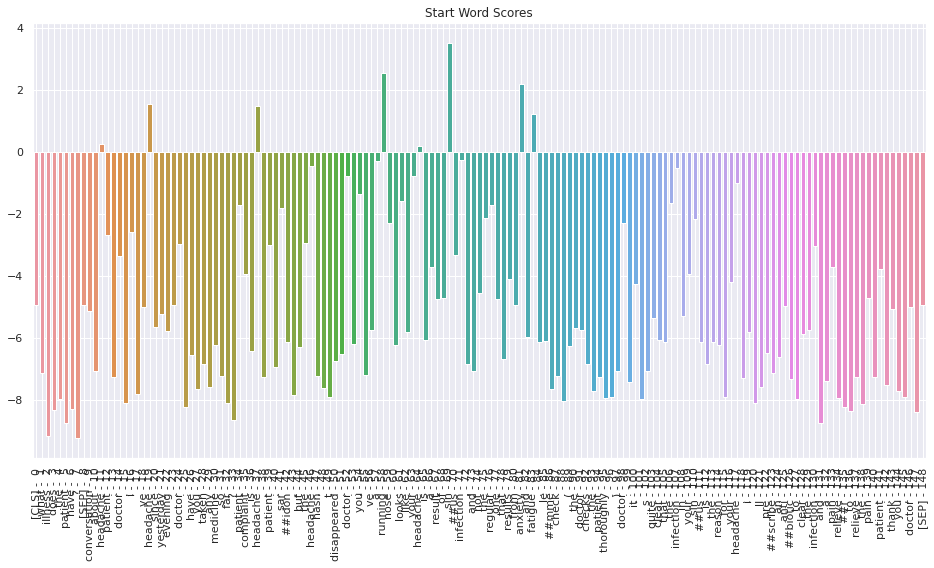

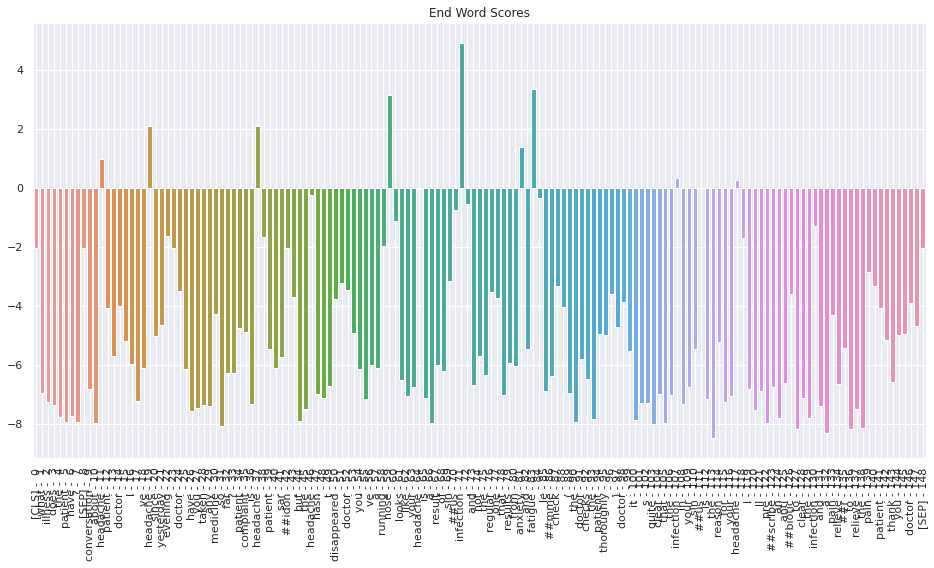

Answer: "sinus infection"


'sinus infection'

In [51]:
longtext_answer('what illness does the patient have?', headache_conv)

Query has 151 tokens.



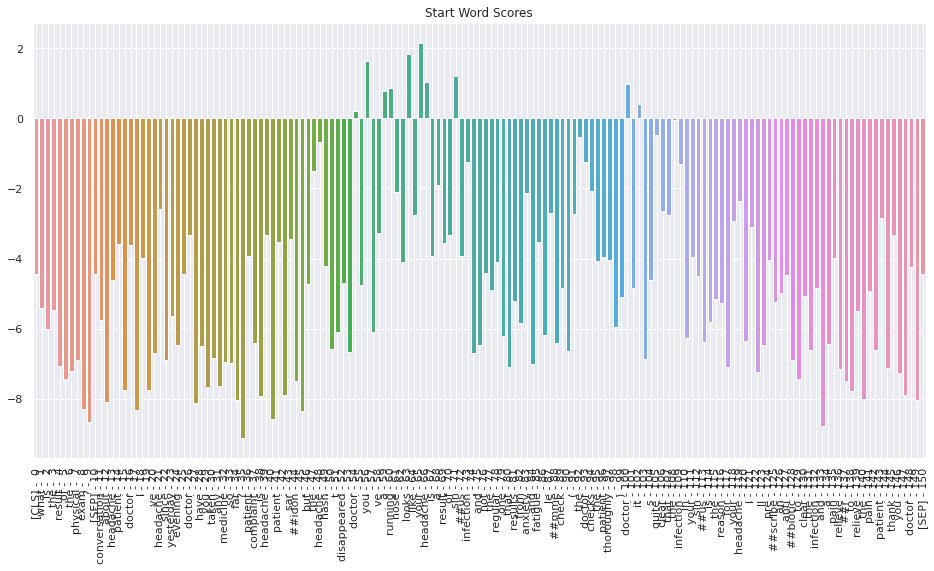

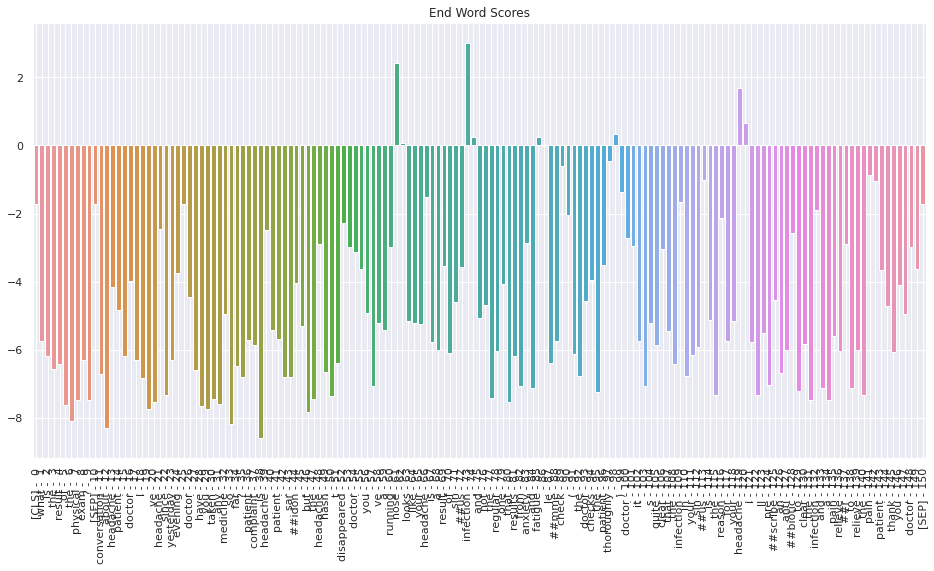

Answer: "your headache is a result of sinus infection"


'your headache is a result of sinus infection'

In [52]:
longtext_answer('What is the result of the physical exam?', headache_conv)

Query has 148 tokens.



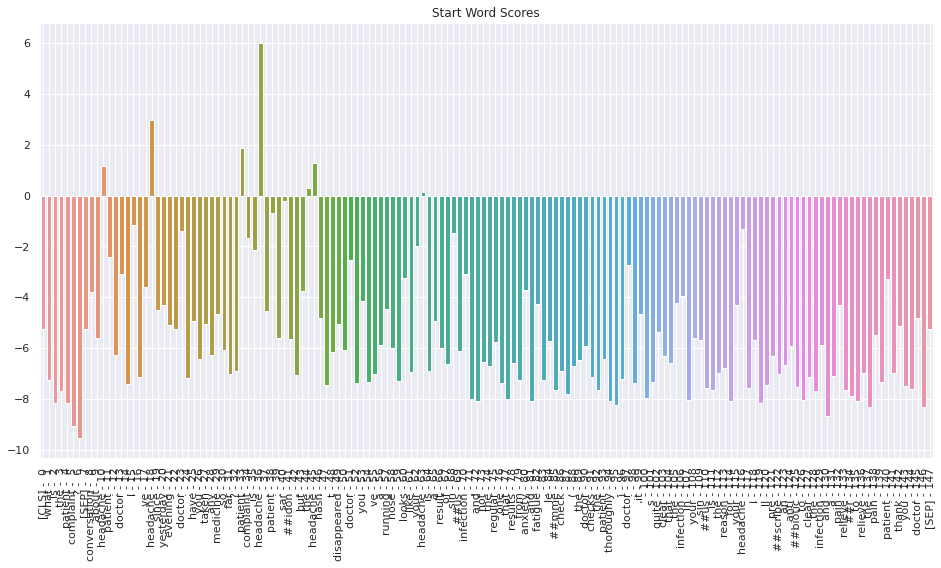

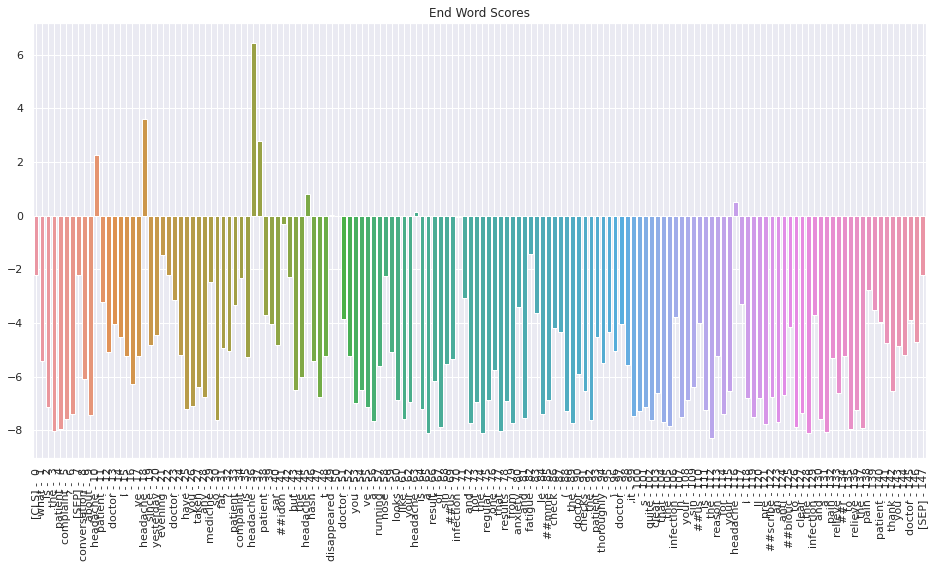

Answer: "headache"


'headache'

In [56]:
longtext_answer('What is the patient complaint?', headache_conv)

In [29]:
stomache_conv = str("""
Patient: I’ve stomach ache and loose motions since last night. I also vomited few times in the night.

Doctor: What did you eat yesterday?

Patient: I ate some snacks on the roadside eatery. It’s likely a result of that.

Doctor: Likely you ate contaminated food. Because of diarrhea, you’ve lost plenty of body fluids. You need to be hydrated. Drink water regularly. Mix some Glucon-D powder or Electral in it. Fruit juice is fine too. Avoid caffeine, dairy products, and solid foods at least till evening. And get plenty of rest.

Patient: Any medicines, doctor.

Doctor: Yes, I’m prescribing few to control diarrhea.

Patient: Thank you, doctor.

""")

Query has 170 tokens.



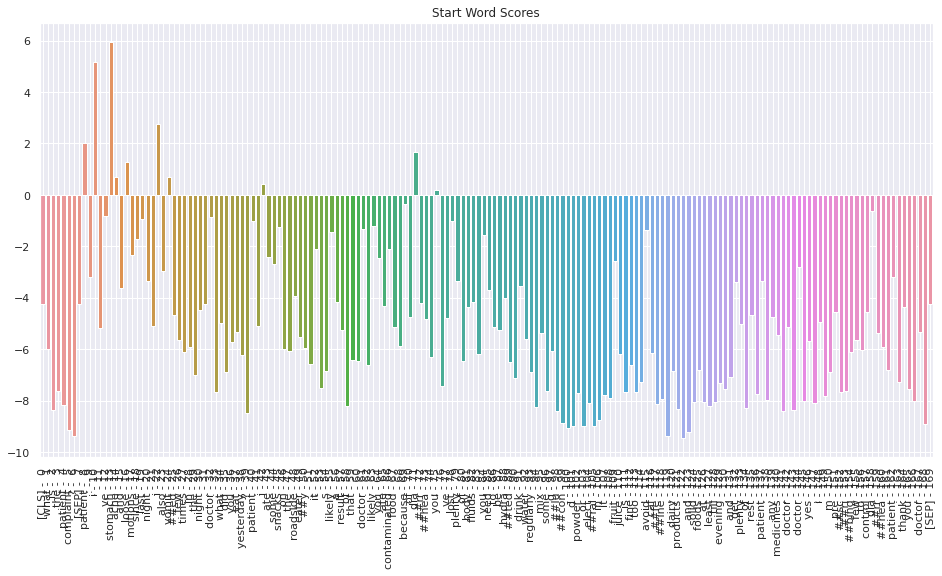

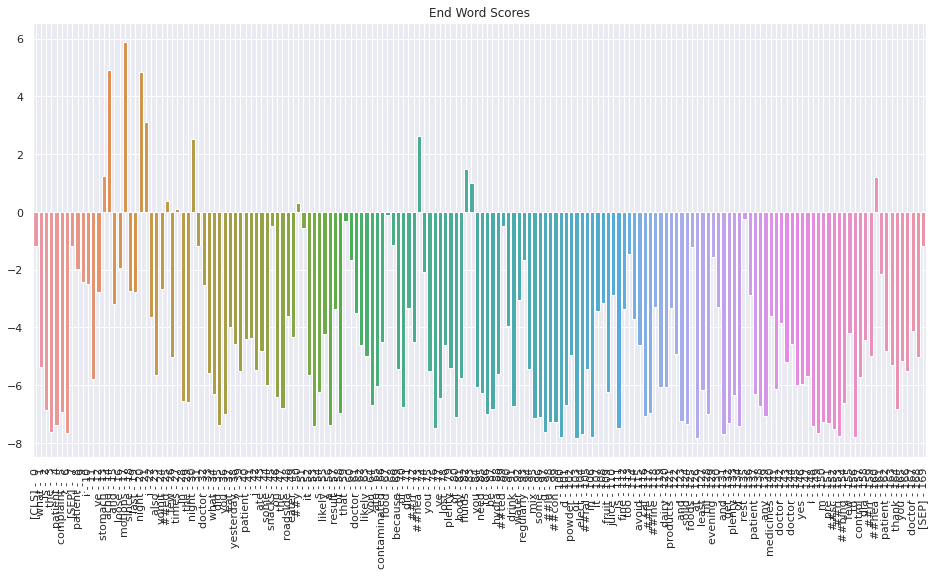

Answer: "stomach ache and loose motions"


'stomach ache and loose motions'

In [30]:
longtext_answer('What is the patient complaint?', stomache_conv)

Query has 173 tokens.



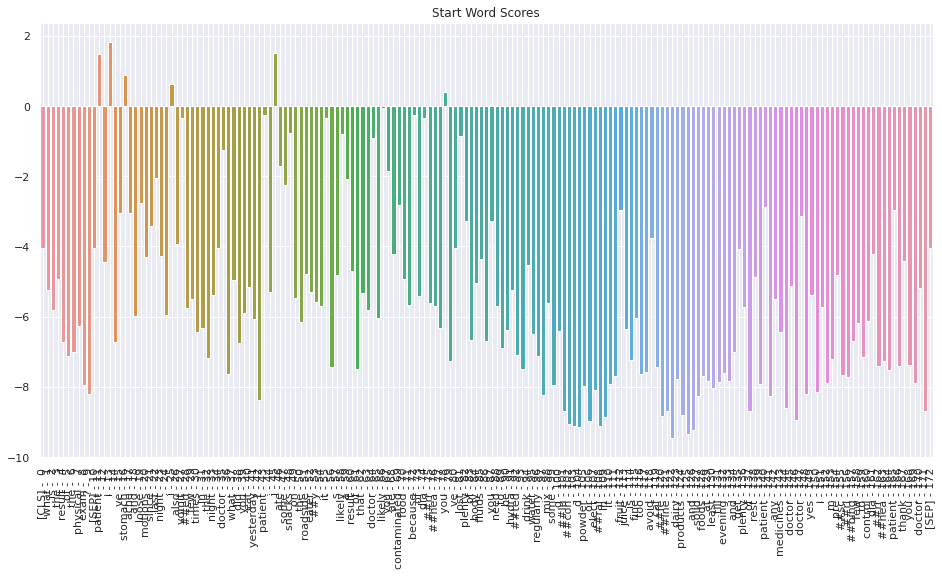

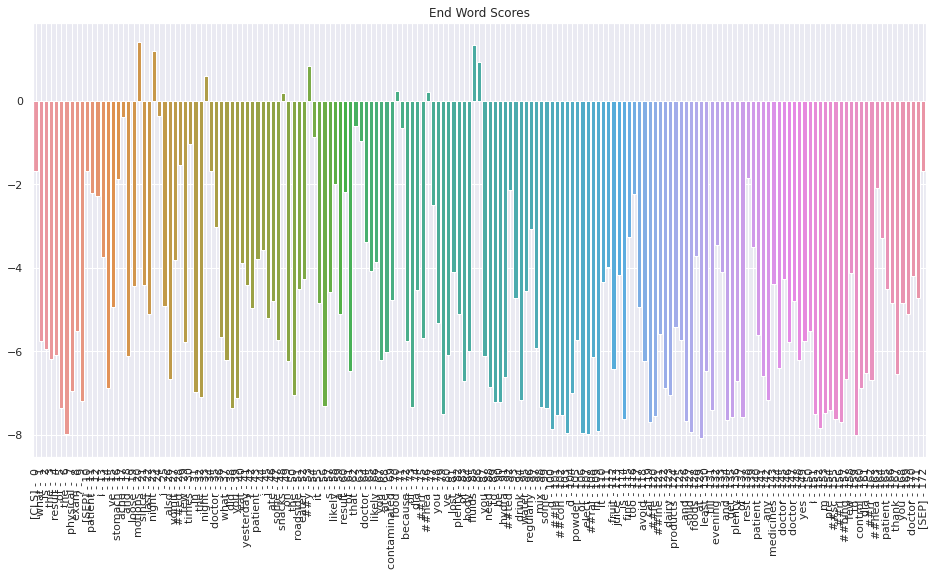

Answer: "i ’ ve stomach ache and loose motions"


'i ’ ve stomach ache and loose motions'

In [31]:
longtext_answer('What is the result of the physical exam?', stomache_conv)

Query has 171 tokens.



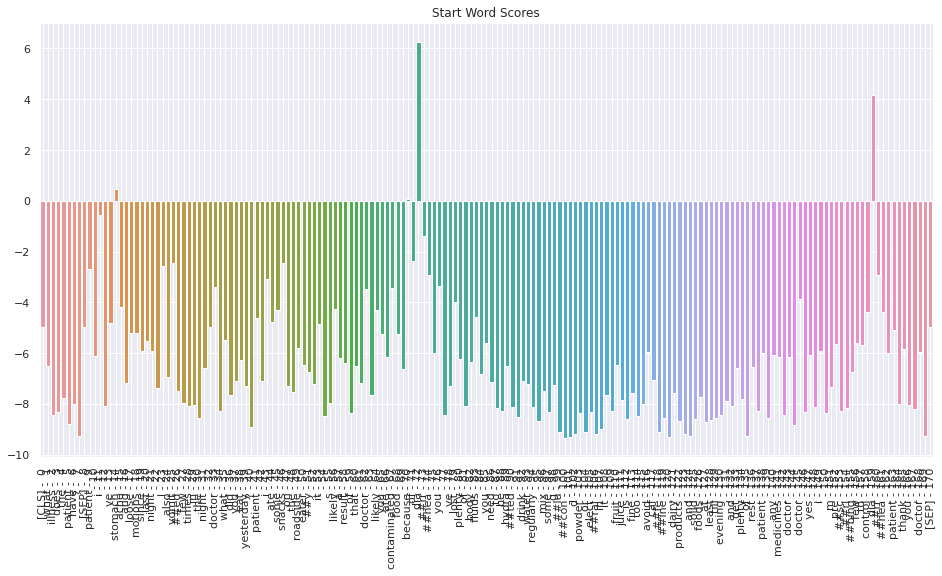

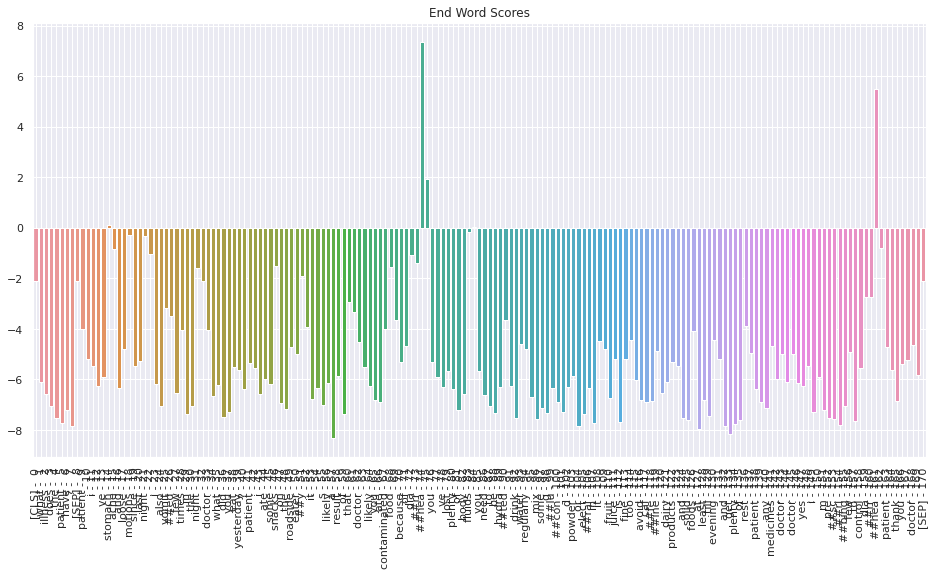

Answer: "diarrhea"


'diarrhea'

In [32]:
longtext_answer('what illness does the patient have?', stomache_conv)

Query has 170 tokens.



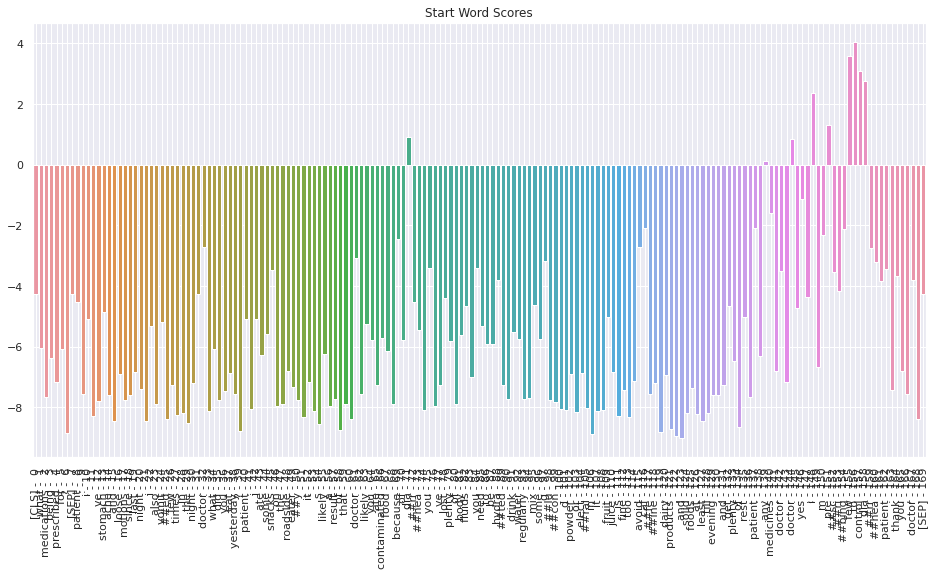

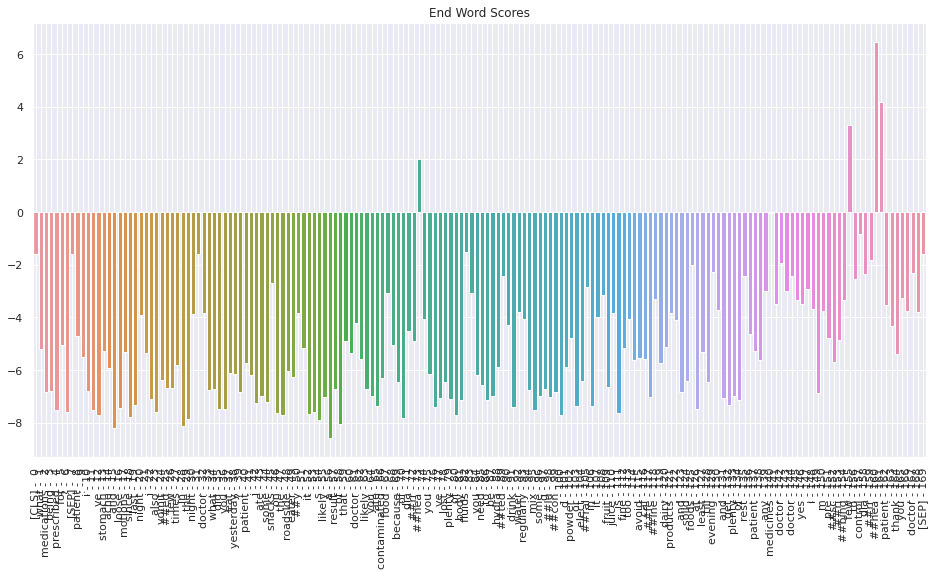

Answer: "to control diarrhea"


'to control diarrhea'

In [33]:
longtext_answer('what medications being prescribed for?', stomache_conv)